# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

загружаем необходимые для работы библиотеки

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


Загружаем данные с помощью **pd.read_csv**

In [2]:
data = pd.read_csv('/datasets/Churn.csv')


### 1.1 Первичное исследование данных

Выводим первые 10 строчек таблицы для первичного осмотра данных.
Используем метод **head**

In [3]:
display(data.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


По этим данным можем сделать вывод:
* столбцы Geography и Gender содержат только буквенные выражения, которые бесполезны для обучения модели. Их необходимо преобразовать
* столбец RowNumber и CustomerId содержит только уникальное значение по логике по этому не информативен для моделей.
* столбец Surname также не информативен для моделей т.к. вряд ли от фамилии зависит история в банке (если это не фамилия Абрамович)

Проверим данные с помощью **describe**

In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Исходя из этих данных можем сделать следующие выводы:
* явных выбросов у нас нет если судить по средним и минимальным и максимальным значениям
* пропуски есть только в одном столбце **Tenure**
* нет отрицательных значений, что тоже не плохо =)

Финально рассмотрим данные с помощью метода **info**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Делаем следующие наблюления:
* пропуски есть в одном столбце Tenure
* тип данных также неправильно указан также для этого столбца. Количество недвижимости может быть только целым числом.

In [7]:
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


### План действий:

1. заполнить пропуски в столбце Tenure
2. сменить тип данных Tenure
3. удалить столбцы RowNumber, CustomerId, Surname т.к. они не информативны для модели
4. преобразовать признаки Geography и Gender
5. проверить данные на выбросы и распределение 
6. разбить данные на выборки

### 1.2 Заполнение пропусков

Посмотрим на строки в которых есть пропуски, есть ли там какая то очевидная закономерность.

In [8]:
display(data[data['Tenure'].isnull()].head(20))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Никаких явных закономерностей обнаружить не удалось поэтому считаю допустимым заполнить пропуски медианой по столбцу.

заполняем пропуски с помощью **fillna**

In [9]:
data['Tenure'].fillna(0,inplace=True)

проверяем заполнение.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


всё ок двигаемся дальше

### 1.3 Смена типа данных 

Меняем тип данных с помощью **astype**

In [11]:
data['Tenure'] = data['Tenure'].astype(int)

Проверяем результат.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [13]:
display(data.head(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Всё ок, двигаемся дальше.

### 1.4 Удаление лишних столбцов.

Удаляем лишнее с помощью **drop**

In [14]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

Проверяем результат.

In [15]:
display(data.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Столбцы удалились успешно, двигаемся дальше.

### 1.5 Преобразование признаков

Сначала преобразуем признак **Gender**

Проверим нет ли странных значений кроме Male, Female. В современном мире может быть, что угодно.

In [16]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Всё окей, можем преобразовывать.

Преобразуем признаки.

In [17]:
data.loc[:,'Gender'] = (data.Gender =='Male').astype(int)

Проверим результат.

In [18]:
display(data.head(10))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,1,44,8,113755.78,2,1,0,149756.71,1
6,822,France,1,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,0,29,4,115046.74,4,1,0,119346.88,1
8,501,France,1,44,4,142051.07,2,0,1,74940.50,0
9,684,France,1,27,2,134603.88,1,1,1,71725.73,0


In [19]:
data['Gender'].value_counts()

1    5457
0    4543
Name: Gender, dtype: int64

Всё ок, двигаемся дальше.

Используем OHE преобразование для столбца **Geography**

In [20]:
dummies_geography = pd.get_dummies(data['Geography'])

Посмотрим получившиеся признаки.

In [21]:
display(dummies_geography)

,France,Germany,Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,0,1,0


Всё ок, можем добавлять данные к общему датасету с помощью **join**

In [22]:
data = data.join(dummies_geography)

Проверим результат.

In [23]:
display(data.head(10))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
5,645,Spain,1,44,8,113755.78,2,1,0,149756.71,1,0,0,1
6,822,France,1,50,7,0.00,2,1,1,10062.80,0,1,0,0
7,376,Germany,0,29,4,115046.74,4,1,0,119346.88,1,0,1,0
8,501,France,1,44,4,142051.07,2,0,1,74940.50,0,1,0,0
9,684,France,1,27,2,134603.88,1,1,1,71725.73,0,1,0,0


Всё ок, двигаемся дальше.

Преобразуем данные методом **OE**

Загружаем метод **OrdinalEncoder**

In [24]:
enc = OrdinalEncoder()

Применяем ко всему дата фрейму.

In [25]:
geog_od = pd.DataFrame(enc.fit_transform(data),
                            columns=data.columns)

Присваиваем преобразованные признаки к основму датасету.

In [26]:
data['Geography'] = geog_od['Geography'].astype(int)

Проверим результат.

In [27]:
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


### 1.6 Разделение на выборки

Поделим данные на выборки в пропорции:      
* 80% тренировочная выборка
* 10% валидационная выборка 
* 10% тестовая выборка

Используя **train_test_split** поделим данные на 80% и 20% 

In [28]:
data_train, data_mid = train_test_split(data,  test_size=0.20, random_state=12345)

Теперь разделим оставшиеся 20% данных на тестовую и валидационную выборку.

In [29]:
data_valid, data_test = train_test_split(data_mid,  test_size=0.50, random_state=12345)

Создадим наборы данных для обучения и ответы.
Я буду использовать два разнных датасета для разных моделей.
Набор с признаками **OHE** буду использовать для модели регрессии, а с **OE** для "деревянных" моделей

In [30]:
features_train_ohe = data_train.drop(['Exited','Geography'], axis=1)
features_train_oe = data_train.drop(['Exited','Spain','France','Germany'], axis=1)
target_train = data_train['Exited']

Аналогично 

In [31]:
features_valid_ohe = data_valid.drop(['Exited','Geography'], axis=1)
features_valid_oe = data_valid.drop(['Exited','Spain','France','Germany'], axis=1)
target_valid = data_valid['Exited']

Аналогично

In [32]:
features_test_ohe = data_test.drop(['Exited','Geography'], axis=1)
features_test_oe = data_test.drop(['Exited','Spain','France','Germany'], axis=1)
target_test = data_test['Exited']

Теперь данные подготовлены для дальнейшего обучения

# 2. Исследование задачи

### 2.1 Исследование баланса классов.

Изучим баланс классов в нашем датасете.

In [33]:
print(data['Exited'].value_counts())

0    7963
1    2037
Name: Exited, dtype: int64


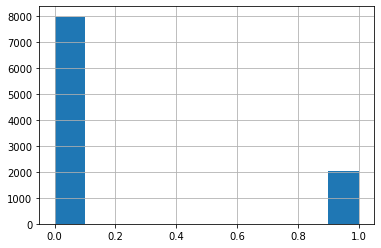

In [34]:
data['Exited'].hist()

Наблюдается большой дисбаланс классов. Отрицательных значений в 4 раза больше чем положительных. Это грозит недоубуенностью модели для положительных прогнозов и переобученностью для отрицательных.

### 2.2. Обучение и валидация модели без учёта дизбаланса классов

### 2.2.1 Модель DecisionTreeClassifier

Найдём лучшие гиперпараметры с помощью **GridSearchCV**

Зададим параметры для тестирования.

In [35]:
param_grid_dt = {'max_depth':[depth for depth in range(1,15)],
              'min_samples_split':[split for split in range(2,10,1)],
              'min_samples_leaf':[leaf for leaf in range(1,10,1)]}

Зададим модель.

In [36]:
gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid_dt)

Обучим модель для нахождения лучших параметров.

In [37]:
gs_dt.fit(features_train_oe, target_train)

Выведем лучшие параметры.

In [38]:
gs_dt.best_params_

Обучим модель с лучшими параметрами.

In [39]:
dt = DecisionTreeClassifier(max_depth =5, 
                            min_samples_leaf =2,
                            min_samples_split = 2,
                            random_state=12345)

In [40]:
dt.fit(features_train_oe, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Сделаем предсказания по тренировочной и валидационной выборкам.

In [41]:
predictions_dt_train = dt.predict(features_train_oe)
predictions_dt_valid = dt.predict(features_valid_oe)

Посмотрим значени метрики F1 и AUC-ROC

In [42]:
print('Train F1=',f1_score(target_train, predictions_dt_train))
print('Train AUC-ROC=',roc_auc_score(target_train, predictions_dt_train))
print('Valid F1=',f1_score(target_valid, predictions_dt_valid))
print('Valid AUC-ROC',roc_auc_score(target_valid, predictions_dt_valid))


Train F1= 0.5456
Train AUC-ROC= 0.6955258118760874
Valid F1= 0.5539358600583091
Valid AUC-ROC 0.6962724014336918


Также выведем общий репорт по точности, полноте и F1 мере.

In [43]:
 print(classification_report(target_train,predictions_dt_train))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6390
           1       0.77      0.42      0.55      1610

    accuracy                           0.86      8000
   macro avg       0.82      0.70      0.73      8000
weighted avg       0.85      0.86      0.84      8000



In [44]:
 print(classification_report(target_valid,predictions_dt_valid))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       775
           1       0.81      0.42      0.55       225

    accuracy                           0.85      1000
   macro avg       0.83      0.70      0.73      1000
weighted avg       0.84      0.85      0.83      1000



**Вывод**       
Дерево решений достаточно хорошо обучилось на поиск отрицательных ответов, но как и предполагалось с положительными возникла проблема ( Recall всего лишь 0.42) из за недостатка данных для обучения.

### 2.2.1 Модель RandomForestClassifier

Теперь аналогично проверим как будет аботать Лес.

In [45]:
param_grid_rf = {'n_estimators': [n_estim for n_estim in range(10,160,10)],
                'max_depth': [depth for depth in range(1,10,1)],
                'min_samples_leaf':[leaf for leaf in range(1,10,1)]}

In [46]:
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf)


In [47]:
gs_rf.fit(features_train_oe, target_train)

%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


In [48]:
gs_rf.best_params_

In [49]:
rf = RandomForestClassifier(max_depth=9, min_samples_leaf=1, n_estimators=140, random_state=12345)

In [50]:
rf.fit(features_train_oe, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [51]:
predictions_rf_train = dt.predict(features_train_oe)
predictions_rf_valid = dt.predict(features_valid_oe)

In [52]:
print('Train F1=',f1_score(target_train, predictions_rf_train))
print('Train AUC-ROC=',roc_auc_score(target_train, predictions_rf_train))
print('Valid F1=',f1_score(target_valid, predictions_rf_valid))
print('Valid AUC-ROC',roc_auc_score(target_valid, predictions_rf_valid))

Train F1= 0.5456
Train AUC-ROC= 0.6955258118760874
Valid F1= 0.5539358600583091
Valid AUC-ROC 0.6962724014336918


In [53]:
 print(classification_report(target_train,predictions_rf_train))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6390
           1       0.77      0.42      0.55      1610

    accuracy                           0.86      8000
   macro avg       0.82      0.70      0.73      8000
weighted avg       0.85      0.86      0.84      8000



In [54]:
 print(classification_report(target_valid,predictions_rf_valid))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       775
           1       0.81      0.42      0.55       225

    accuracy                           0.85      1000
   macro avg       0.83      0.70      0.73      1000
weighted avg       0.84      0.85      0.83      1000



**Вывод:**    
Ситуация аналогична предыдущему опыту, модель очень плохо определяет положительный класс.

### 2.2.1 Модель LogisticRegression

Аналогично проверим логистическую регрессию, только будем использовать другой набор данных. С признаками преобразованными методом OHE (регрессию больше "любит" такое преобразование)

In [55]:
param_grid_logres = {'penalty':['l1','l2'],
                    'C':[0.1,0.5]}

In [56]:
gs_logres = GridSearchCV(LogisticRegression(), param_grid = param_grid_logres)
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [57]:
gs_logres.fit(features_train_ohe, target_train)

In [58]:
gs_logres.best_params_

In [59]:
logres = LogisticRegression(C=0.1, penalty='l1')

In [60]:
logres.fit(features_train_ohe, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
predictions_logres_train = logres.predict(features_train_ohe)
predictions_logres_valid = logres.predict(features_valid_ohe)

In [62]:
print('Train F1=',f1_score(target_train, predictions_logres_train))
print('Train AUC-ROC=',roc_auc_score(target_train, predictions_logres_train))
print('Valid F1=',f1_score(target_valid, predictions_logres_valid))
print('Valid AUC-ROC',roc_auc_score(target_valid, predictions_logres_valid))

Train F1= 0.3151515151515151
Train AUC-ROC= 0.5895542336142459
Valid F1= 0.28
Valid AUC-ROC 0.5720430107526883


In [63]:
 print(classification_report(target_train,predictions_logres_train))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6390
           1       0.63      0.21      0.32      1610

    accuracy                           0.82      8000
   macro avg       0.73      0.59      0.60      8000
weighted avg       0.79      0.82      0.78      8000



In [64]:
 print(classification_report(target_valid,predictions_logres_valid))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       775
           1       0.56      0.19      0.28       225

    accuracy                           0.78      1000
   macro avg       0.68      0.57      0.58      1000
weighted avg       0.75      0.78      0.74      1000



**Вывод:**       
Логистическая регрессия справилась с определением положительного класса ещё хуже.

# 3. Борьба с дисбалансом

## 3.1 Увеличение выборки


В результате предыдущих исследований стало очевидно, что все модели плохо обучены для положительного класса (1), поэтому нам необходимо увеличить тренировочную выборку путём добавления строк с положительным ответом. Уменьшать отрицательный класс в нашем случае нельзя так как у нас мало данных.

Выделим положительные и отрицательные классы в отдельную выборку.

In [65]:
exited_1 = data_train[data_train['Exited']==1]
exited_0 = data_train[data_train['Exited']==0]

Посчитаем насколько одни данных больше чем других.

In [66]:
dif = exited_0.shape[0]-exited_1.shape[0]

Создадим новые данные.

In [67]:
up_data = exited_1.sample(dif, replace=True)

Добавим их к нашей тренировочной выборке.

In [68]:
features_train_ohe_up = pd.concat([features_train_ohe, up_data.drop(['Exited','Geography'], axis=1)])
features_train_oe_up = pd.concat([features_train_oe,  up_data.drop(['Exited','Spain','France','Germany'], axis=1)])
target_train_up = pd.concat([target_train,  up_data['Exited']])

Проверим размер данных до upsampling'a и после.

In [69]:
features_train_ohe_up.shape

(12780, 12)

In [70]:
features_train_ohe.shape

(8000, 12)

Всё корректно, данных стало больше.

## 3.2 Обучение моделей после upsampling'a


### 3.2.1  Модель DecisionTreeClassifier


Проведём нахожление гиперпараметров, обучение и тестирование на валидационной выборке как делали раньше, процесс подробно описывать снова не буду.

In [71]:
gs_dt_up = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid_dt)

In [72]:
gs_dt_up.fit(features_train_oe_up, target_train_up)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
     

In [73]:
gs_dt_up.best_params_

{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [109]:
dt_up = DecisionTreeClassifier(max_depth =14, 
                            min_samples_leaf =1,
                            min_samples_split = 2,
                            random_state=12345,
                            class_weight='balanced')

In [110]:
dt_up.fit(features_train_oe_up, target_train_up)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=14,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [111]:
predictions_dt_train_up = dt_up.predict(features_train_oe_up)
predictions_dt_valid_up = dt_up.predict(features_valid_oe)

In [112]:
print('Train F1=',f1_score(target_train_up, predictions_dt_train_up))
print('Train AUC-ROC=',roc_auc_score(target_train_up, predictions_dt_train_up))
print('Valid F1=',f1_score(target_valid, predictions_dt_valid_up))
print('Valid AUC-ROC',roc_auc_score(target_valid, predictions_dt_valid_up))

Train F1= 0.9602638846271861
Train AUC-ROC= 0.9594679186228481
Valid F1= 0.49087221095334693
Valid AUC-ROC 0.6740501792114695


In [87]:
 print(classification_report(target_train_up,predictions_dt_train_up))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      6390
           1       0.94      0.98      0.96      6390

    accuracy                           0.96     12780
   macro avg       0.96      0.96      0.96     12780
weighted avg       0.96      0.96      0.96     12780



In [89]:
 print(classification_report(target_valid,predictions_dt_valid_up))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       775
           1       0.45      0.54      0.49       225

    accuracy                           0.75      1000
   macro avg       0.65      0.67      0.66      1000
weighted avg       0.77      0.75      0.76      1000



**Вывод:**      
Нам удалось немного улучшить полноту и точность, но этого недостаточно для достижения целевого паказателя в 0.59, попробуем другие модели

### 3.3.2 Модель RandomForestClassifier

In [ ]:
gs_rf_up = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf)


In [ ]:
gs_rf_up.fit(features_train_oe_up, target_train_up)

In [ ]:
gs_rf_up.best_params_

In [113]:
rf_up = RandomForestClassifier(max_depth=9, min_samples_leaf=1, n_estimators=140, random_state=12345,class_weight='balanced')

In [114]:
rf_up.fit(features_train_oe_up, target_train_up)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=140, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [115]:
predictions_rf_train_up = rf_up.predict(features_train_oe_up)
predictions_rf_valid_up = rf_up.predict(features_valid_oe)

In [116]:
print('Train F1=',f1_score(target_train_up, predictions_rf_train_up))
print('Train AUC-ROC=',roc_auc_score(target_train_up, predictions_rf_train_up))
print('Valid F1=',f1_score(target_valid, predictions_rf_valid_up))
print('Valid AUC-ROC',roc_auc_score(target_valid, predictions_rf_valid_up))

Train F1= 0.8724501944598778
Train AUC-ROC= 0.8742566510172143
Valid F1= 0.6356275303643725
Valid AUC-ROC 0.7766308243727599


In [99]:
 print(classification_report(target_train_up,predictions_rf_train_up))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      6390
           1       0.89      0.86      0.87      6390

    accuracy                           0.87     12780
   macro avg       0.87      0.87      0.87     12780
weighted avg       0.87      0.87      0.87     12780



In [100]:
 print(classification_report(target_valid,predictions_rf_valid_up))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       775
           1       0.58      0.70      0.64       225

    accuracy                           0.82      1000
   macro avg       0.75      0.78      0.76      1000
weighted avg       0.83      0.82      0.83      1000



**Вывод:**      
Нам удалось улучшить показатели до целевых.

### 3.3.3 Модель LogisticRegression

In [ ]:
gs_logres_up = GridSearchCV(LogisticRegression(), param_grid = param_grid_logres)
%time

In [ ]:
gs_logres_up.fit(features_train_ohe, target_train)

In [ ]:
gs_logres_up.best_params_

In [117]:
logres_up = LogisticRegression(C=0.1, penalty='l1',class_weight='balanced')

In [118]:
logres_up.fit(features_train_ohe_up, target_train_up)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
predictions_logres_train_up = logres_up.predict(features_train_ohe_up)
predictions_logres_valid_up = logres_up.predict(features_valid_ohe)

In [127]:
print('Train F1=',f1_score(target_train_up, predictions_logres_train_up))
print('Train AUC-ROC=',roc_auc_score(target_train_up, predictions_logres_train_up))
print('Valid F1=',f1_score(target_valid, predictions_logres_valid_up))
print('Valid AUC-ROC',roc_auc_score(target_valid, predictions_logres_valid_up))

Train F1= 0.7031632089611106
Train AUC-ROC= 0.7055555555555555
Valid F1= 0.5008025682182986
Valid AUC-ROC 0.6905376344086022


In [126]:
 print(classification_report(target_train_up,predictions_logres_train_up))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      6390
           1       0.71      0.70      0.70      6390

    accuracy                           0.71     12780
   macro avg       0.71      0.71      0.71     12780
weighted avg       0.71      0.71      0.71     12780



In [124]:
 print(classification_report(target_valid,predictions_logres_valid_up))

              precision    recall  f1-score   support

           0       0.89      0.69      0.77       775
           1       0.39      0.69      0.50       225

    accuracy                           0.69      1000
   macro avg       0.64      0.69      0.64      1000
weighted avg       0.77      0.69      0.71      1000



**Вывод**        
Логистическая регрессия всё равно не справляется с задачей при наших условиях.

# 4. Тестирование модели

Протестируем нашу лучшую модель на тестовой выборке.

In [107]:
predictions_rf_up_test = rf_up.predict(features_test_oe)


In [108]:
print(f1_score(target_test, predictions_rf_up_test))

0.6043478260869566


Нам удалось достичь целового показателя в F1 = 0.59

**Вывод**

Нам удалось достичь цели с помощью модели 